## ASSUMPTIONS OF MPT

- Investors are rational and avoid risks whenever possible

- Investors aim for the maximum returns for their investment

- All investors share the aim maximizing their expected returns

- Commissions and taxes on the market are left out of consideration

- All investors have access to the same sources and level of all necessary information about investment decisions

- Investors have unlimited access to borrow and lend money at the risk free rate

In [46]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

sns.set_style('darkgrid')
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline

## Read in Data from Quandl

In [18]:
with open('../quandl_key.txt', 'r') as f:
    quandl.ApiConfig.api_key = f.read()

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'F']
data = quandl.get_table('WIKI/PRICES', 
                        ticker=tickers,
                        qopts={'columns':['ticker', 'date', 'adj_close']},
                        date={'gte':'2014-1-1', 'lte':'2016-12-31'},
                        paginate=True
                       ).set_index('date')
data.head()

,ticker,adj_close
date,,
2016-12-30,MSFT,60.788710
2016-12-29,MSFT,61.532183
2016-12-28,MSFT,61.620226
2016-12-27,MSFT,61.903920
2016-12-23,MSFT,61.864790


In [55]:
df = data.pivot(columns='ticker', values='adj_close')
df_ret = df.pct_change(1).dropna()
df_ret.head()

ticker,AAPL,AMZN,F,GOOG,MSFT
date,,,,,
2014-03-28,-0.00,-0.00,0.01,0.00,0.02
2014-03-31,-0.00,-0.01,0.01,-0.01,0.02
2014-04-01,0.01,0.02,0.05,0.02,0.01
2014-04-02,0.00,-0.00,0.01,-0.00,-0.00
2014-04-03,-0.01,-0.02,-0.00,0.00,-0.01


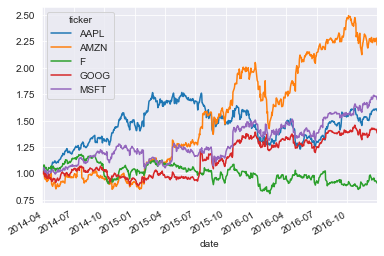

In [66]:
df_ret.add(1).cumprod().plot()

## Formulas

(1) $Annualized\ Return = (1 + cummulative\ return)^{(365\ /\ days\ held)} - 1$

(2) $Annualized\ Covariance = (Daily\ Covariance) * 252$

(3) $Variance = w^{T} \cdot (cov \cdot w)$

(4) $Correlation = \frac{cov}{std_{1} * std_{2}}$

In [64]:
df_ret.add(1).prod() ** (365 / df_ret.shape[0]) - 1

ticker
AAPL    0.28
AMZN    0.52
F      -0.05
GOOG    0.18
MSFT    0.32
dtype: float64

In [72]:
df_ret.cov() * 252

ticker,AAPL,AMZN,F,GOOG,MSFT
ticker,,,,,
AAPL,0.06,0.03,0.02,0.02,0.03
AMZN,0.03,0.10,0.02,0.04,0.03
F,0.02,0.02,0.05,0.02,0.02
GOOG,0.02,0.04,0.02,0.06,0.03
MSFT,0.03,0.03,0.02,0.03,0.06


### Simulate portfolio combinations

In [140]:
num_assets = len(tickers)
num_pfls = 50_000 # arbitrary

pfl_rets = []
pfl_vols = []
stk_weights = []

num_trade_days = 252
rets_annual = df_ret.add(1).prod() ** (num_trade_days / df_ret.shape[0]) - 1
cov_annual = df_ret.cov() * num_trade_days

for pfl in range(num_pfls):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    rets = np.dot(weights, rets_annual)
    vols = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    
    pfl_rets.append(rets)
    pfl_vols.append(vols)
    stk_weights.append(weights)
    
pfl_dic = {'Returns': pfl_rets,
           'Volatility':pfl_vols,
          }

for counter, symbol in enumerate(tickers):
    pfl_dic[symbol + '_weight'] = [weight[counter] for weight in stk_weights]
    
df = pd.DataFrame(pfl_dic)
df.head()

,Returns,Volatility,AAPL_weight,MSFT_weight,AMZN_weight,GOOG_weight,F_weight
0,0.16,0.18,0.23,0.16,0.20,0.23,0.18
1,0.17,0.19,0.24,0.21,0.16,0.27,0.12
2,0.19,0.20,0.18,0.22,0.06,0.31,0.23
3,0.18,0.19,0.30,0.08,0.03,0.35,0.25
4,0.15,0.19,0.19,0.08,0.13,0.45,0.15


In [141]:
df['Sharpe'] = df['Returns'] / df['Volatility']

sharpe_pfl = df[df['Sharpe'] == df['Sharpe'].max()]
min_var_pfl = df[df['Volatility'] == df['Volatility'].min()]

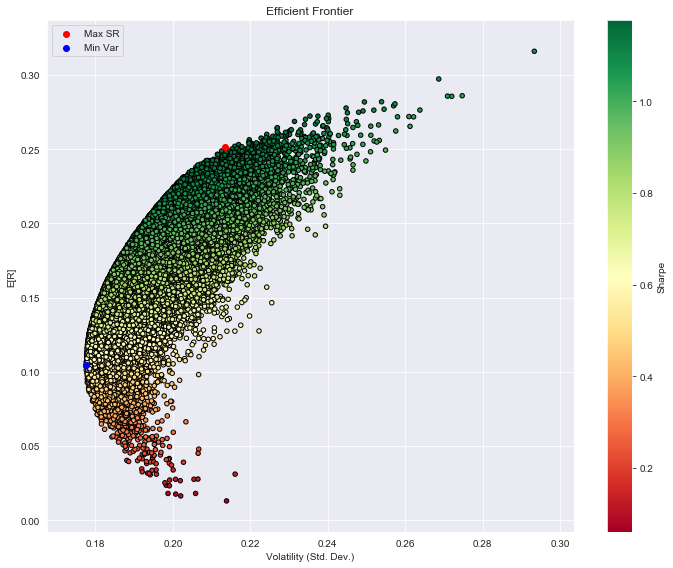

In [142]:
df.plot.scatter(x='Volatility', 
                y='Returns', 
                c='Sharpe',
                cmap='RdYlGn',
                edgecolors='black',
                figsize=(10,8),
                sharex=False, # must do to show x-ticks and label
                grid=True
               )

plt.scatter(x=sharpe_pfl['Volatility'], 
            y=sharpe_pfl['Returns'], 
            c='red',
            label='Max SR'
           )
plt.scatter(x=min_var_pfl['Volatility'], 
            y=min_var_pfl['Returns'], 
            c='blue',
            label='Min Var'
           )

plt.ylabel('E[R]')
plt.xlabel('Volatility (Std. Dev.)')
plt.title('Efficient Frontier')
plt.tight_layout()
plt.legend()

In [143]:
sharpe_pfl

,Returns,Volatility,AAPL_weight,MSFT_weight,AMZN_weight,GOOG_weight,F_weight,Sharpe
45806,0.25,0.21,0.25,0.39,0.00,0.00,0.35,1.18


In [144]:
min_var_pfl

,Returns,Volatility,AAPL_weight,MSFT_weight,AMZN_weight,GOOG_weight,F_weight,Sharpe
24775,0.10,0.18,0.26,0.01,0.32,0.24,0.17,0.59
